GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frederik135. Use `wandb login --relogin` to force relogin



  | Name      | Type    | Params
--------------------------------------
0 | model     | LSTM    | 10.7 K
1 | criterion | MSELoss | 0     
--------------------------------------
10.7 K    Trainable params
0         Non-trainable params
10.7 K    Total params
0.043     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.
Restoring states from the checkpoint path at ./cyclical_data_forecast/aqhiymuj/checkpoints/epoch=79-step=10000.ckpt
Loaded model weights from the checkpoint at ./cyclical_data_forecast/aqhiymuj/checkpoints/epoch=79-step=10000.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

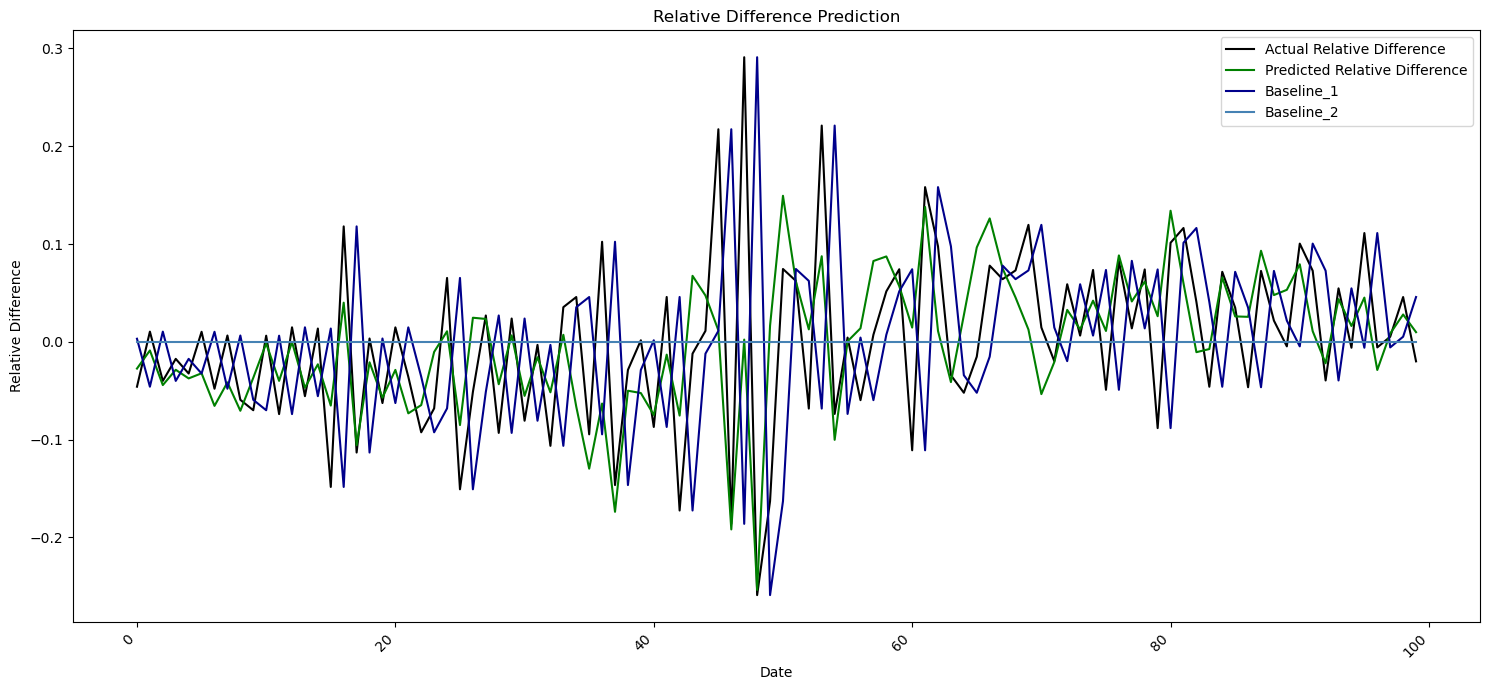

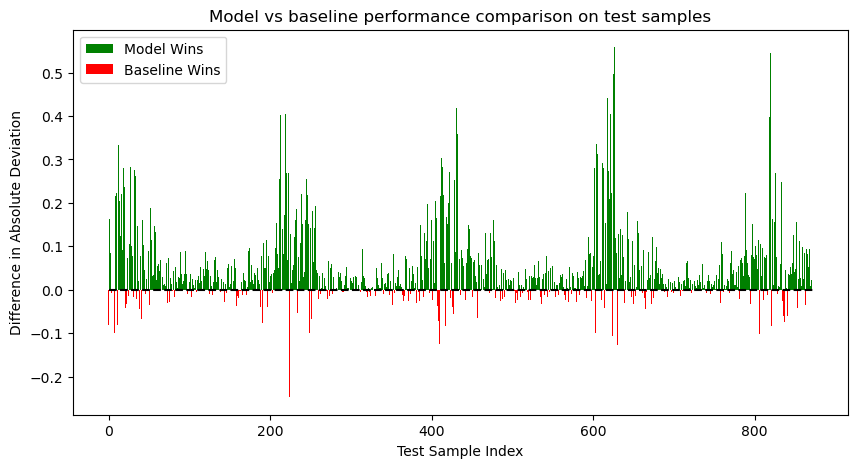

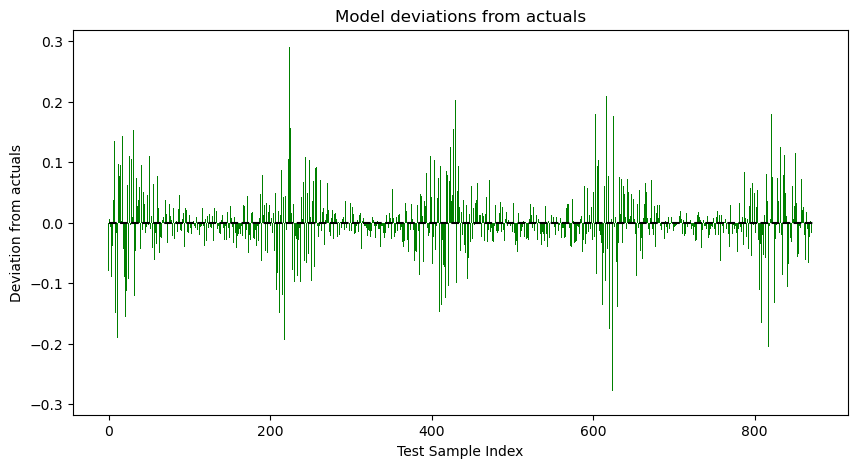

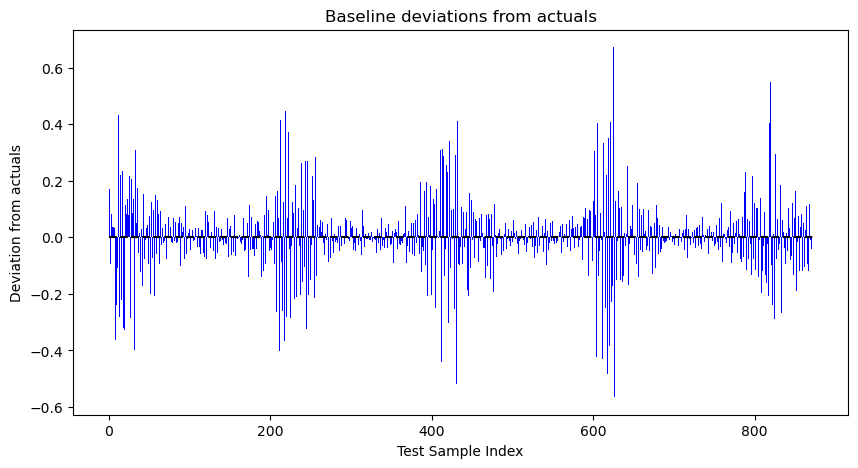

Preparing to log the table...
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.01755109243094921
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
train_loss_epoch,█▇▃▃▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_loss_step,██▅▅▃▂▃▂▃▂▃▂▃▃▃▃▃▃▃▂▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁
trainer/global_step,▁▁▁▁▁▁▁▁▁▁▁▃▁▃▁▁▁▁▄▁▅▁▅▁▂▂▂▆▂▆▂▂▂▂▇▂█▂█▂
val_loss_epoch,█▇▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_step,█▁▅▁▁▅▁▂▅▁▅▁▁▄▁▂▅▁▁▅▁▅▁▂▅▁▁▅▁▂▁▂▅▁▁▅▁▂▃▁
epoch,80
test_loss,0.01755
train_loss_epoch,0.00014
train_loss_step,0.00192


In [1]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import wandb
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from config import num_epochs, learning_rate, wandb_config, model
# from preprocessing import stock_df
from cyclical_preprocessing import train_loader, val_loader, test_loader, label_scaler

class StockPredictionModule(pl.LightningModule):
    def __init__(self, model, label_scaler, train_loader, val_loader, test_loader):
        super().__init__()
        self.model = model
        self.label_scaler = label_scaler
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.criterion = nn.MSELoss()
        # self.criterion = torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean', label_smoothing=0.0)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("test_loss", loss)
        return loss

    def on_test_epoch_end(self):
        predictions, actuals = [], []
        for seqs, labels in self.test_loader:
            seqs, labels = seqs.to(self.device), labels.to(self.device)
            output = self(seqs)
            predictions.extend(output.view(-1).detach().cpu().numpy())
            actuals.extend(labels.view(-1).detach().cpu().numpy())

        predictions_rescaled = list(self.label_scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten())
        actuals_rescaled = list(self.label_scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten())
        baseline_rescaled = [actuals_rescaled[0]] + actuals_rescaled[:-1]
        baseline_constant = [0.0] * len(predictions_rescaled)

        len_test_set = len(predictions)

        fig, ax = plt.subplots(figsize=(15, 7))
        ax.plot(actuals_rescaled[-100:], label='Actual Relative Difference', color='black', linestyle='-')
        ax.plot(predictions_rescaled[-100:], label='Predicted Relative Difference', color='green', linestyle='-')
        ax.plot(baseline_rescaled[-100:], label='Baseline_1', color='darkblue', linestyle='-')
        ax.plot(baseline_constant[-100:], label='Baseline_2', color='steelblue', linestyle='-')
        # ax.plot(test_dates[-100:], arima_predictions[-100:], label='Baseline', color='orange', linestyle='-') 
        ax.set_title('Relative Difference Prediction')
        ax.set_xlabel('Date')
        ax.set_ylabel('Relative Difference')
        ax.legend()
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
        filename = "plot.png"
        fig.savefig(filename)
        wandb.log({"Relative Difference Prediction": wandb.Image(filename)})
        os.remove(filename)
        plt.close(fig)
        
        """
        # Use plotting with rebasing to visualize the predictions as prices
        rebase_period = 30
        predicted_prices = [actual_closing_prices[0]]
        for i, relative_change in enumerate(predictions_rescaled[1:], 1):
            if i % rebase_period == 0:
                predicted_prices.append(actual_closing_prices[i])
            else:
                predicted_prices.append(predicted_prices[-1] * relative_change)
        baseline_prices = [actual_closing_prices[0]] + list(actual_closing_prices[:-1])

        fig, ax = plt.subplots(figsize=(15, 7))
        ax.plot(test_dates, actual_closing_prices, label='Actual Price', color='black', linestyle='-')
        ax.plot(test_dates, predicted_prices, label='Predicted Price', color='green', linestyle='-')
        ax.plot(test_dates, baseline_prices, label='Baseline', color='blue', linestyle='-') 
        ax.set_title('Price predictions based on last price in validation set')
        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Price')
        ax.legend()
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
        filename = "plot.png"
        fig.savefig(filename)
        wandb.log({"Stock Price Prediction": wandb.Image(filename)})
        os.remove(filename)
        plt.close(fig)
        """

        """
        # We use for the first value the actual closing price and then multiply the relative change for each following timestep
        actual_prices = [actual_closing_prices[0]]
        for i in range(1, len(actuals_rescaled)):
            actual_prices.append(actual_prices[i-1] * actuals_rescaled[i])
        prediction_prices = [actual_closing_prices[0]]
        for i in range(1, len(predictions_rescaled)):
            prediction_prices.append(prediction_prices[i-1] * predictions_rescaled[i])
        baseline_prices = [actual_prices[0]] + actual_prices[:-1]
        fig, ax = plt.subplots(figsize=(15, 7))
        ax.plot(test_dates, actual_prices, label='Actual Price', color='black', linestyle='-')
        ax.plot(test_dates, prediction_prices, label='Predicted Price', color='green', linestyle='-')
        ax.plot(test_dates, baseline_prices, label='Baseline', color='blue', linestyle='-')
        ax.set_title('Stock Price Prediction')
        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Price')
        ax.legend()
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
        filename = "plot.png"
        fig.savefig(filename)
        wandb.log({"Stock Price Prediction": wandb.Image(filename)})
        os.remove(filename)
        plt.close(fig)
        """
        
        net_abs_dev = torch.tensor([abs(predictions_rescaled[i] - actuals_rescaled[i]) for i in range(len(actuals_rescaled))])
        baseline_abs_dev = torch.tensor([abs(baseline_rescaled[i] - actuals_rescaled[i]) for i in range(len(actuals_rescaled))])
        diff_pos = torch.relu(baseline_abs_dev - net_abs_dev).reshape(-1).tolist()
        diff_min = (-torch.relu(net_abs_dev - baseline_abs_dev)).reshape(-1).tolist()
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.set_title('Model vs baseline performance comparison on test samples')
        ax.hlines(0, xmin=0, xmax=len(actuals_rescaled), linestyles='dashed', colors='black')
        ax.bar(list(range(len(actuals_rescaled))), diff_pos, color='g', label='Model Wins', width=1.0)
        ax.bar(list(range(len(actuals_rescaled))), diff_min, color='r', label='Baseline Wins', width=1.0)
        ax.legend()
        ax.set_xlabel('Test Sample Index')
        ax.set_ylabel('Difference in Absolute Deviation')
        plt.show()
        filename = "comparison_plot.png"
        fig.savefig(filename)
        wandb.log({"Model vs Baseline Performance Comparison": wandb.Image(filename)})
        os.remove(filename)
        plt.close(fig)

        model_actual_dev = torch.tensor([predictions_rescaled[i] - actuals_rescaled[i] for i in range(len(actuals_rescaled))])
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.set_title('Model deviations from actuals')
        ax.hlines(0, xmin=0, xmax=len(actuals_rescaled), linestyles='dashed', colors='black')
        ax.bar(list(range(len(actuals_rescaled))), model_actual_dev, color='g', label='Model Wins', width=1.0)
        ax.set_xlabel('Test Sample Index')
        ax.set_ylabel('Deviation from actuals')
        plt.show()
        filename = "comparison_plot.png"
        fig.savefig(filename)
        wandb.log({"Model deviations from actuals": wandb.Image(filename)})
        os.remove(filename)
        plt.close(fig)

        baseline_actual_dev = torch.tensor([baseline_rescaled[i] - actuals_rescaled[i] for i in range(len(actuals_rescaled))])
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.set_title('Baseline deviations from actuals')
        ax.hlines(0, xmin=0, xmax=len(actuals_rescaled), linestyles='dashed', colors='black')
        ax.bar(list(range(len(actuals_rescaled))), baseline_actual_dev, color='b', label='Baseline Wins', width=1.0)
        ax.set_xlabel('Test Sample Index')
        ax.set_ylabel('Deviation from actuals')
        plt.show()
        filename = "comparison_plot.png"
        fig.savefig(filename)
        wandb.log({"Baseline deviations from actuals": wandb.Image(filename)})
        os.remove(filename)
        plt.close(fig)

        actuals_rescaled = np.array(actuals_rescaled)
        predictions_rescaled = np.array(predictions_rescaled)
        baseline_rescaled = np.array(baseline_rescaled)

        model_mse = mean_squared_error(actuals_rescaled, predictions_rescaled)
        model_rmse = np.sqrt(model_mse)
        model_mae = mean_absolute_error(actuals_rescaled, predictions_rescaled)
        model_r2 = r2_score(actuals_rescaled, predictions_rescaled)
        model_mape = np.mean(np.abs((actuals_rescaled - predictions_rescaled) / (actuals_rescaled + 1e-8)))
        pct_change_labels = [label for label in actuals_rescaled]
        pct_change_predictions = [pred for pred in predictions_rescaled]
        hit_rate_model = np.mean(np.sign(pct_change_labels) == np.sign(pct_change_predictions))
        
        baseline_mse = mean_squared_error(actuals_rescaled, baseline_rescaled)
        baseline_rmse = np.sqrt(baseline_mse)
        baseline_mae = mean_absolute_error(actuals_rescaled, baseline_rescaled)
        baseline_r2 = r2_score(actuals_rescaled, baseline_rescaled)
        baseline_mape = np.mean(np.abs((actuals_rescaled - baseline_rescaled) / (actuals_rescaled + 1e-8)))
        pct_change_baseline = [base for base in baseline_rescaled]
        hit_rate_baseline = np.mean(np.sign(pct_change_labels) == np.sign(pct_change_baseline))

        model_metrics = {
            "mse": model_mse,
            "rmse": model_rmse,
            "mae": model_mae,
            "mape": model_mape,
            "r2": model_r2,
            "hit_rate": hit_rate_model,
        }
        baseline_metrics = {
            "mse": baseline_mse,
            "rmse": baseline_rmse,
            "mae": baseline_mae,
            "mape": baseline_mape,
            "r2": baseline_r2,
            "hit_rate": hit_rate_baseline
        }
        model_baseline_performance_metrics = {
            "mse": round((baseline_mse / model_mse - 1) * 100, 2),
            "rmse": round((baseline_rmse / model_rmse - 1) * 100, 2),
            "mae": round((baseline_mae / model_mae - 1) * 100, 2),
            "mape": round((baseline_mape / model_mape - 1) * 100, 2),
            "r2": round((model_r2 / baseline_r2 - 1) * 100, 2),
            "hit_rate": round((hit_rate_model / hit_rate_baseline - 1) * 100, 2),
        }

        print("Preparing to log the table...")
        metrics_table = wandb.Table(columns=["metric", "model", "baseline", "model-baseline performance comparison [%]"])
        for metric in model_metrics.keys():
            metrics_table.add_data(metric, model_metrics[metric], baseline_metrics[metric], model_baseline_performance_metrics[metric])
        wandb.log({"metrics": metrics_table})

def main():
    seed_value = 42
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

    torch.set_float32_matmul_precision("medium")
    wandb_logger = WandbLogger(project="cyclical_data_forecast", log_model="all", config=wandb_config)
    
    module = StockPredictionModule(model=model, label_scaler=label_scaler, train_loader=train_loader, val_loader=val_loader, test_loader=test_loader)

    if torch.cuda.is_available(): 
        accelerator = "gpu"
        devices = 1
    elif torch.backends.mps.is_built():
        accelerator = "mps"
        devices = 1
    else:
        accelerator = None
        devices = None

    trainer = Trainer(max_epochs=num_epochs, logger=wandb_logger, accelerator=accelerator, devices=devices, enable_checkpointing=True)
    trainer.fit(module, train_dataloaders=train_loader, val_dataloaders=val_loader)
    trainer.test(dataloaders=test_loader, ckpt_path="best")

    wandb.finish()

if __name__ == "__main__":
    main()



---
### Hyperparameter Optimization (Objective: Minimize validation loss)

In [ ]:
import optuna
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import torch
from models import LSTM, GRU, FCNN
from config import model_config, device, seq_length, architecture
from preprocessing import train_loader, val_loader, test_loader, label_scaler
import wandb

class StockPredictionModule(LightningModule):
    def __init__(self, model, label_scaler, train_loader, val_loader, test_loader):
        super().__init__()
        self.model = model
        self.label_scaler = label_scaler
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.criterion = torch.nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        labels = labels.detach().cpu().numpy()
        y_pred = y_pred.detach().cpu().numpy()

        labels_rescaled = self.label_scaler.inverse_transform(labels.reshape(-1, 1)).flatten()
        predictions_rescaled = self.label_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

        r2 = r2_score(labels_rescaled , predictions_rescaled)
        mse = mean_squared_error(labels_rescaled , predictions_rescaled)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(labels_rescaled , predictions_rescaled)
        mape = np.mean(np.abs((labels_rescaled  - predictions_rescaled) / (predictions_rescaled + 1e-8)))
        pct_change_labels = [label - 1 for label in labels_rescaled]
        pct_change_predictions = [prediction - 1 for prediction in predictions_rescaled]
        hit_rate = np.mean(np.sign(pct_change_labels) == np.sign(pct_change_predictions))

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_r2", r2, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_mse", mse, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_rmse", rmse, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_mae", mae, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_mape", mape, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("hit_rate", hit_rate, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return {"val_loss": loss, "val_r2": r2, "val_mse": mse, "val_rmse": rmse, "val_mae": mae, "val_mape": mape, "hit_rate": hit_rate}


def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    hidden_size = trial.suggest_int('hidden_size', 16, 128)
    dropout_prob = trial.suggest_float('dropout_prob', 0.0, 0.5)

    model_config.update({
        "hidden_layer_size": hidden_size,
        "num_layers": num_layers,
        "dropout_prob": dropout_prob
    })

    wandb_config = {
        "architecture": architecture,
        "learning_rate": learning_rate,
        "num_units": hidden_size,
        "num_layers": num_layers,
        "dropout": dropout_prob,
        "seq_length": seq_length,
        "epochs": 50
    }

    wandb.init(project="optuna_hyperparameter_tuning", entity="frederik135", config=wandb_config, reinit=True)
    model = GRU(**model_config).to(device)
    module = StockPredictionModule(model=model, label_scaler=label_scaler, 
                                   train_loader=train_loader, val_loader=val_loader, test_loader=None)
    module.hparams.learning_rate = learning_rate

    accelerator = "auto"
    devices = 1 if torch.cuda.is_available() or torch.backends.mps.is_built() else None

    wandb_logger = WandbLogger(project="optuna_hyperparameter_tuning", log_model="all", config=wandb_config)
    trainer = Trainer(
        logger=wandb_logger,
        max_epochs=70,
        callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=10)],
        accelerator=accelerator,
        devices=devices,
        enable_checkpointing=False,
        enable_progress_bar=False
    )

    trainer.fit(module, train_dataloaders=train_loader, val_dataloaders=val_loader)
    val_result = trainer.validate(module, dataloaders=val_loader, verbose=False)
    val_loss = val_result[0].get('val_loss', float('inf'))
    wandb.finish()
    return val_loss


seed_value = 42
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)
torch.set_float32_matmul_precision("medium")

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best hyperparameters: ", study.best_trial.params)

In [ ]:
print("Best hyperparameters: ", study.best_trial.params)

### Hyperparameter Optimization (Objective: Maximize R2 Score)

In [ ]:
import optuna
import numpy as np
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import torch
from models import LSTM, GRU, FCNN
from config import model_config, device, seq_length, architecture
from preprocessing import train_loader, val_loader, test_loader, label_scaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import wandb

class StockPredictionModule(LightningModule):
    def __init__(self, model, label_scaler, train_loader, val_loader, test_loader):
        super().__init__()
        self.model = model
        self.label_scaler = label_scaler
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.criterion = torch.nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        labels = labels.detach().cpu().numpy()
        y_pred = y_pred.detach().cpu().numpy()
        r2 = r2_score(labels, y_pred)
        mse = mean_squared_error(labels, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(labels, y_pred)
        mape = np.mean(np.abs((labels - y_pred) / (y_pred + 1e-8)))

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_r2", r2, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_mse", mse, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_rmse", rmse, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_mae", mae, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_mape", mape, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return {"val_loss": loss, "val_r2": r2, "val_mse": mse, "val_rmse": rmse, "val_mae": mae, "val_mape": mape}

def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    hidden_size = trial.suggest_int('hidden_size', 16, 128)
    dropout_prob = trial.suggest_float('dropout_prob', 0.0, 0.5)

    model_config.update({
        "hidden_layer_size": hidden_size,
        "num_layers": num_layers,
        "dropout_prob": dropout_prob
    })

    wandb_config = {
        "learning_rate": learning_rate,
        "num_units": hidden_size,
        "num_layers": num_layers,
        "dropout": dropout_prob,
        "seq_length": seq_length,
        "epochs": 50
    }

    wandb.init(project="optuna_hyperparameter_tuning", entity="frederik135", config=wandb_config, reinit=True)
    model = GRU(**model_config).to(device)
    module = StockPredictionModule(model=model, label_scaler=label_scaler, 
                                   train_loader=train_loader, val_loader=val_loader, test_loader=test_loader)
    module.hparams.learning_rate = learning_rate

    accelerator = "auto"
    devices = 1 if torch.cuda.is_available() or torch.backends.mps.is_built() else None

    wandb_logger = WandbLogger(project="optuna_hyperparameter_tuning", log_model="all")
    trainer = Trainer(
        logger=wandb_logger,
        max_epochs=70,
        callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=10)],
        accelerator=accelerator,
        devices=devices,
        enable_checkpointing=False,
        enable_progress_bar=False
    )

    trainer.fit(module, train_dataloaders=train_loader, val_dataloaders=val_loader)
    val_result = trainer.validate(module, dataloaders=val_loader, verbose=False)
    val_loss = val_result[0].get('val_loss', float('inf'))
    val_r2 = val_result[0].get('val_r2', float('-inf')) 

    wandb.finish()

    return -np.exp(val_r2 + 1.0)

seed_value = 42
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)
torch.set_float32_matmul_precision("medium")

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best hyperparameters: ", study.best_trial.params)

In [ ]:
print("Best hyperparameters: ", study.best_trial.params)

### Hyperparameter Optimization for FCNN (Objective: Minimize validation loss)

In [ ]:
import optuna
import torch
import torch.nn as nn
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from models import FCNN_model
from config import device, seq_length, num_features
from preprocessing import train_loader, val_loader, label_scaler
import wandb
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

class StockPredictionModule(LightningModule):
    def __init__(self, model, label_scaler, train_loader, val_loader, test_loader):
        super().__init__()
        self.model = model
        self.label_scaler = label_scaler
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.criterion = torch.nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        labels = labels.detach().cpu().numpy()
        y_pred = y_pred.detach().cpu().numpy()

        labels_rescaled = self.label_scaler.inverse_transform(labels.reshape(-1, 1)).flatten()
        predictions_rescaled = self.label_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

        r2 = r2_score(labels_rescaled , predictions_rescaled)
        mse = mean_squared_error(labels_rescaled , predictions_rescaled)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(labels_rescaled , predictions_rescaled)
        mape = np.mean(np.abs((labels_rescaled  - predictions_rescaled) / (predictions_rescaled + 1e-8)))
        pct_change_labels = [label - 1 for label in labels_rescaled]
        pct_change_predictions = [prediction - 1 for prediction in predictions_rescaled]
        hit_rate = np.mean(np.sign(pct_change_labels) == np.sign(pct_change_predictions))

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_r2", r2, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_mse", mse, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_rmse", rmse, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_mae", mae, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_mape", mape, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("hit_rate", hit_rate, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return {"val_loss": loss, "val_r2": r2, "val_mse": mse, "val_rmse": rmse, "val_mae": mae, "val_mape": mape, "hit_rate": hit_rate}


def objective(trial):
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 3)
    hidden_layers = [trial.suggest_int(f'hidden_size_{i}', 32, 128) for i in range(num_hidden_layers)]
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    dropout_prob = trial.suggest_float('dropout_prob', 0.0, 0.5)

    model_config = {
        "seq_length": seq_length,
        "num_features": num_features,
        "hidden_layers": hidden_layers,
        "n_out": 1, 
        "dropout_prob": dropout_prob
    }

    wandb_config = {
        "architecture": "FCNN",
        "learning_rate": learning_rate,
        "hidden_layers": hidden_layers,
        "dropout_prob": dropout_prob,
        "seq_length": seq_length,
        "epochs": 50
    }

    wandb.init(project="fcnn_hyperparameter_test", entity="frederik135", config=wandb_config, reinit=True)

    model = FCNN_model(**model_config).to(device)
    module = StockPredictionModule(model=model, label_scaler=label_scaler, 
                                   train_loader=train_loader, val_loader=val_loader, test_loader=None)
    module.hparams.learning_rate = learning_rate

    if torch.cuda.is_available():
        accelerator = "gpu"
        devices = 1
    elif hasattr(torch, 'has_mps') and torch.backends.mps.is_built():
        accelerator = "mps"
        devices = 1
    else:
        accelerator = None
        devices = None

    wandb_logger = WandbLogger(project="fcnn_hyperparameter_test", log_model="all", config=wandb_config)
    trainer = Trainer(
        logger=wandb_logger,
        max_epochs=70,
        callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=10)],
        accelerator=accelerator,
        devices=devices,
        enable_checkpointing=False,
        enable_progress_bar=False
    )

    trainer.fit(module, train_dataloaders=train_loader, val_dataloaders=val_loader)
    val_result = trainer.validate(module, dataloaders=val_loader, verbose=False)
    val_loss = val_result[0].get('val_loss', float('inf'))

    wandb.finish()
    return val_loss

seed_value = 42
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)
torch.set_float32_matmul_precision("medium")

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best hyperparameters: ", study.best_trial.params)
